In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np

In [3]:
from collections import OrderedDict

In [4]:
from PIL.Image import Image

In [5]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torchvision import (transforms, datasets)

In [ ]:
from fastai.vision import *

## Train Letters classificartion with convolutional neural networkm

#### Prepare data

In [8]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])

## Image search

In [13]:
from typing import Union
from pathlib import Path
from tqdm import tqdm

In [7]:
import cv2

In [8]:
from torch import no_grad
from torch.jit import ScriptModule
from torchvision.models import (resnet34, resnet50, wide_resnet50_2)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
path = Path('data')
path.mkdir(exist_ok=True)

In [11]:
size = 256
imsz = 224
IMG_SUFF = {'.jpg', '.jpeg', '.png'}

In [14]:
class ToPILImage(object):
    """Convert inout image to PIL image"""

    def __init__(self, mode=None):
        super().__init__()
        self.to_pil = transforms.ToPILImage(mode=mode)

    def convert(self, img: Union[np.ndarray, Image]):
        """
        Converts image to the PIL format
        Args:
            img: inout image

        Returns:
            converted image
        """
        return img if isinstance(img, Image) else self.to_pil(img)

    def __call__(self, *args, **kwargs):
        return self.convert(*args, **kwargs)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        if self.to_pil.mode is not None:
            format_string += f'mode={self.to_pil.mode}'
        format_string += ')'
        return format_string


class Img2Vec(object):
    """Model wrapper for image embedding"""

    def __init__(self, backbone: Union[nn.Module, ScriptModule], trfm: transforms, device: str = 'cpu'):
        super().__init__()
        self.device = torch.device(device)
        self.backbone = (backbone.eval() if hasattr(backbone, 'eval') else backbone).to(device)
        self.trfm = trfm

    def preprocess(self, *xs: np.ndarray) -> Tensor:
        """
        Transform data before model
        Args:
            *xs: input data

        Returns:
            processed data for model
        """
        return torch.stack([self.trfm(x) for x in xs]).to(self.device)

    @no_grad()
    def forward(self, *xs: np.ndarray) -> np.ndarray:
        tns = self.preprocess(*xs)
        rts = self.backbone(tns)
        y = rts.cpu().data.numpy()

        return y

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [15]:
vec_trsfm = transforms.Compose([ToPILImage(mode='RGB'),
                                transforms.Resize(size),
                                transforms.CenterCrop(imsz),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#### Prepare data

In [16]:
search_path = path / 'search'

In [17]:
dir_paths = [dp for dp in search_path.iterdir() if dp.is_dir()]

In [18]:
dir_paths

[PosixPath('data/search/places'),
 PosixPath('data/search/fortresses'),
 PosixPath('data/search/streets'),
 PosixPath('data/search/charches_small'),
 PosixPath('data/search/churches'),
 PosixPath('data/search/rivers')]

In [19]:
img_pts = [im_pt for dp in dir_paths for im_pt in dp.iterdir() if im_pt.suffix in IMG_SUFF]

In [20]:
def read_img(im_pt):
    img = cv2.imread(str(im_pt), cv2.IMREAD_ANYCOLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return img

In [21]:
imgs = [read_img(ip) for ip in img_pts]

#### Initialize features extractor

In [22]:
cut = 1

In [23]:
body = wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /Users/levan/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


In [24]:
body

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [26]:
class FlattenLayer(nn.Module):
    """Flatten layer"""

    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.flatten(x, 1)

In [27]:
backbone = nn.Sequential(*list(body.children())[:-cut])
net = nn.Sequential(backbone, FlattenLayer())

In [28]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [29]:
img_vec = Img2Vec(net, vec_trsfm, device='cpu')

In [32]:
pimgs = tqdm(imgs, desc='Vectorizing images', total=len(imgs))

Vectorizing images:   0%|          | 0/156 [00:00<?, ?it/s]

In [33]:
vecs = [img_vec(im)[0] for im in pimgs]

Vectorizing images: 100%|██████████| 156/156 [01:13<00:00,  2.11it/s]


In [34]:
vecs[0].shape, len(vecs)

((2048,), 156)

In [35]:
img_vecs = list(zip(imgs, vecs))

In [36]:
img_vecs

[(array([[[167, 194, 223],
          [167, 194, 223],
          [169, 196, 225],
          ...,
          [151, 180, 212],
          [150, 179, 211],
          [149, 178, 210]],
  
         [[167, 194, 223],
          [168, 195, 224],
          [169, 196, 225],
          ...,
          [151, 180, 212],
          [150, 179, 211],
          [150, 179, 211]],
  
         [[168, 195, 224],
          [169, 196, 225],
          [170, 197, 226],
          ...,
          [152, 181, 213],
          [151, 180, 212],
          [150, 179, 211]],
  
         ...,
  
         [[ 88,  97, 106],
          [ 89,  96, 104],
          [113, 114, 119],
          ...,
          [ 72,  68,  56],
          [132, 129, 122],
          [145, 142, 137]],
  
         [[ 96, 105, 114],
          [100, 107, 115],
          [125, 126, 131],
          ...,
          [ 68,  66,  54],
          [135, 134, 129],
          [152, 152, 150]],
  
         [[ 61,  70,  79],
          [ 72,  79,  87],
          [106, 107, 112

In [ ]:
for im in imgs:
    plt.imshow(im)
    plt.show()
    plt.close()

#### Compare vectors

In [37]:
from scipy.spatial.distance import cosine

In [38]:
import matplotlib.pyplot as plt

In [39]:
def top_vecs(qi, top_k=5):
    qv = img_vec(qi)[0]
    resul_pts = [(cosine(qv, vc), pt) for pt, vc in img_vecs]
    resul_pts = sorted(resul_pts, key=lambda x: x[0], reverse=False)
    resul_pts = resul_pts[:top_k]
    
    return resul_pts

#### Query images

- ch_1.jpg
- ch_2.jpg
- ft_1.jpeg
- ft_2.jpg
- rv_1.jpeg
- rv_2.jpeg
- st_1.jpeg
- st_2.jpeg
- st_3.jpg
- ct_1.jpg
- ct_2.jpg

In [40]:
query_path = path / 'queries'
query_path.mkdir(exist_ok=True)

In [84]:
qim = read_img(query_path / 'ct_1.jpg')

In [85]:
res = top_vecs(qim)

In [86]:
#res

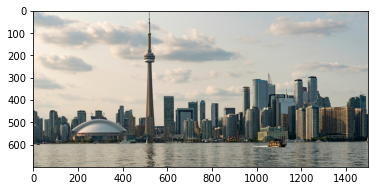

In [87]:
plt.imshow(qim)
plt.show()
plt.close()

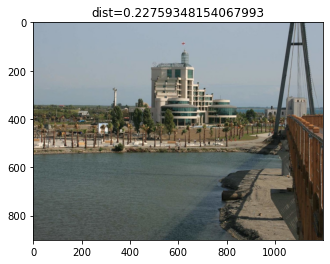

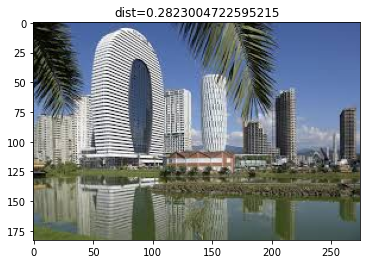

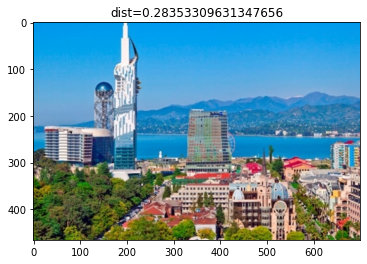

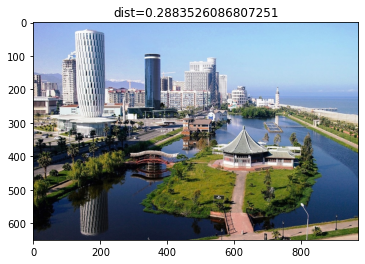

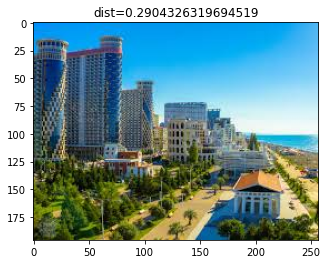

In [88]:
for dist, res_img in res:
    plt.title(f'dist={dist}')
    plt.imshow(res_img)
    plt.show()
    plt.close()